<a href="https://colab.research.google.com/github/hooked-on-mas/AutoGenBook/blob/main/AutoGenBookKR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 사양 수립

아래를 입력한 후, 【모든 셀 실행 (Ctrl + F9)】을 눌러주세요.

In [1]:
# @markdown ## 필수 항목
# @markdown ### 교과서 내용
book_content = "기계 학습과 관련된 선형 대수 교과서" #@param {type:"string"}
# @markdown ### 대략적인 페이지 수
n_pages = 40 # @param {"type":"integer","placeholder":"40"}
# @markdown ### 출력 형식
tex_output = True #@param {type:"boolean"}
pdf_output = True #@param {type:"boolean"}
md_output = True #@param {type:"boolean"}

# @markdown ## 선택 항목
# @markdown ### 예상 독자층
target_readers = "파이썬과 넘파이를 이미 숙지한, 올해부터 기계 학습 연구를 시작한 대학 4학년 학생입니다." #@param {type:"string"}
# @markdown ### 수식의 등장 빈도
equation_frequency_level = 4 #@param {type:"slider", min:1, max:5, step:1}
# @markdown ### 내용 출력 시 장 구성 고려
do_consider_outline = True #@param {type:"boolean"}
# @markdown ### 내용 출력 시 직전 출력 내용 고려
do_consider_previous_sections = True #@param {type:"boolean"}
# @markdown ### 내용에 대한 기타 요청 사항
additional_requirements = "이론 설명 후, Numpy를 사용한 계산 예시를 포함해 주세요." #@param {type:"string"}

if book_content == "":
    print('\033[31m'+'교과서 내용을 지정해 주세요.'+'\033[0m')
if n_pages == 0:
    print('\033[31m'+'페이지 수를 지정해 주세요.'+'\033[0m')


## 프롬프트 정의

In [2]:
# 공통 프롬프트
prompt_common = f"""
다음 내용을 바탕으로 책을 집필합니다.
{book_content}
책 전체의 페이지 수는 {n_pages} 페이지이며, 1페이지당 40행을 예상하고 있습니다.
"""
if target_readers != "":
    prompt_common += f"예상 독자는 다음과 같습니다.\n {target_readers}"
if additional_requirements != "":
    prompt_common += f"또한 다음 사항을 고려해 주세요.\n {additional_requirements}"

# 책과 장의 제목 및 개요 생성용 프롬프트
prompt_book_title = prompt_common + """
위 내용을 바탕으로, 아래와 같은 json 형식으로 책과 장의 제목, 책과 장의 개요를 제시해 주세요.
책의 개요에는 내용의 요약뿐만 아니라, 책의 주요 목적과 다루는 내용의 범위와 깊이에 대해서도 언급해 주세요. 5~10문장 정도로 자세히 작성해 주세요.
또한, 각 장에 할당할 페이지 수를 고려해 주세요. 페이지 수는 0.1 단위로, 예를 들어 0.8 페이지와 같이 기재해 주세요.
더불어, 내용의 의미적 응집성 측면에서 각 장을 세분화할 필요가 있는지 여부(needsSubdivision)를 고려해 주세요. true 또는 false로 답변해 주세요.
추측이나 확인되지 않은 정보는 포함하지 말아 주세요. 제목에는 장 번호를 작성하지 말아 주세요.
절의 개수는 필요에 따라 조정해 주세요.
```json
{{"title": "",
"summary": "",
"childs":
    [{{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }},
    {{"title": "",
    "summary": "",
    "n_pages": ,
    "needsSubdivision":
    }}]
}}
```
"""

# 세분화용 프롬프트
prompt_section_list_creation = prompt_common + """
위 정보를 바탕으로 {book_title}라는 제목의 책을 작성하려고 합니다. 책의 개요는 아래와 같습니다.
{book_summary}
그 중 {target}에 관한 부분을 {n_pages} 페이지로 작성하려고 합니다. 1페이지당 40행을 예상하고 있습니다.
이 부분의 개요는 다음과 같습니다.
{section_summary}
이 부분을 세분화하여 여러 파트로 나누어 주세요.
각 파트의 제목과 개요를 아래와 같은 json 형식으로 출력해 주세요. 또한, 각 파트에 할당할 페이지 수를 고려해 주세요. 페이지 수는 0.1 단위로, 예를 들어 0.8 페이지와 같이 기재해 주세요.
더불어, 내용의 의미적 응집성 측면에서 각 장을 세분화할 필요가 있는지 여부(needsSubdivision)를 고려해 주세요. true 또는 false로 답변해 주세요.
제목에는 장 또는 절 번호를 작성하지 말아 주세요.
```json
[{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}},
{{"title": "",
"summary": "",
"n_pages": ,
"needsSubdivision":
}}]
```
"""

# 본문 내용 생성용 프롬프트
prompt_content_creation = prompt_common + """
위 정보를 바탕으로 {book_title}라는 제목의 책을 작성하려고 합니다. 책의 개요는 아래와 같습니다.
{book_summary}
그 중 {target}에 관한 부분을 {n_pages} 페이지로 작성하려고 합니다. 1페이지당 40행을 예상하고 있습니다.
이 부분의 개요는 다음과 같습니다.
{section_summary}
{toc_and_summary}
{previous_sections}
이 부분의 내용을 {n_pages} 페이지, 즉 {n_pages} × 40행 분량으로 LaTeX로 출력해 주세요. 프리앰블에 필요한 라이브러리는 모두 임포트되어 있습니다.
추측이나 확인되지 않은 정보는 포함하지 말아 주세요. 제목은 필요 없으며, 본문만 출력해 주세요.
{equation_frequency}
수식에는 equation 환경 또는 align 환경을 사용하고, 다른 환경은 사용하지 말아 주세요.
수식을 중첩하지 않도록, 즉 \\[ \\begin{{align}} \\end{{align}} \\]이 아닌 \\begin{{align}} \\end{{align}}으로 작성해 주세요.
코드를 출력하는 경우 lstlisting 환경을 사용해 주세요. 옵션에는 프로그래밍 언어만 설정해 주세요. 예를 들어, 사용 언어가 Python이라면 \\begin{{lstlisting}}[language=Python]과 같이 해 주세요.
#을 사용할 때는 반드시 \#로 이스케이프해 주세요.
출력 형식은 다음과 같습니다.
```tex
본문 내용
```
"""

## 파라미터 설정

In [3]:
# 파라미터
max_depth = 5 # 1이면 절만, 2이면 소절까지...
max_output_pages = 1.5 # LLM의 최대 출력 페이지 수

book_node_name = "book" # 루트 노드의 이름

openai_api_secret_key_name = 'openai_api' # openai_api를 시크릿 키로 등록했을 때의 변수명
model_name = "gpt-4o" # 모델의 이름

if do_consider_previous_sections:
    n_previous_sections = 1
else:
    n_previous_sections = 0

## 라이브러리 설치 및 임포트

In [4]:
!apt-get update
!apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
!apt-get install -y latexmk
!apt-get install -y texlive-latex-extra
!apt-get install -y texlive-luatex
!apt-get install -y texlive-bibtex-extra biber texlive-fonts-recommended
!apt-get install -y texlive-lang-korean
!apt-get install -y texlive-science
%pip install -qU langchain-openai
%pip install pygraphviz
%pip install pylatex

import os
import re
import json
import networkx as nx
from google.colab import userdata
from IPython.display import Markdown
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from pylatex import Command, Document, Section, Subsection, Package
from pylatex.section import Chapter
from pylatex.utils import NoEscape

from google.colab import files

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [5]:

!apt-get install -y texlive-bibtex-extra biber texlive-fonts-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
biber is already the newest version (2.17-2).
texlive-bibtex-extra is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


## 그래프 생성

In [6]:
book_graph = nx.DiGraph(book_content=book_content, target_readers=target_readers, equation_frequency_level=equation_frequency_level, additional_requirements=additional_requirements)

## 제목 및 각 장 생성

### 함수 정의

In [7]:
def extract_book_and_chapter_contents(markdown_text):
    """
    Markdown 형식의 텍스트에서 처음으로 발견된 JSON 데이터를 추출하고, Python의 딕셔너리 타입으로 변환하여 반환하는 함수입니다.

    Args:
        markdown_text (str): Markdown 형식의 문자열. 이 문자열 안에 JSON 형식의 데이터가 포함되어 있다고 가정합니다.

    Returns:
        dict 또는 None: 올바른 형식의 JSON이 발견되면 딕셔너리 타입으로 반환하고, 발견되지 않거나 파싱에 실패한 경우에는 None을 반환합니다.
    """

    # Markdown에서 JSON의 시작 지점을 찾습니다.
    start_index = markdown_text.find('{')
    if start_index == -1:
        return None

    # 문자열 전체를 순회하면서 중첩된 괄호의 균형을 확인합니다.
    brace_count = 0
    for i in range(start_index, len(markdown_text)):
        if markdown_text[i] == '{':
            brace_count += 1
        elif markdown_text[i] == '}':
            brace_count -= 1

        # 괄호의 균형이 맞으면 그 시점에서 추출합니다.
        if brace_count == 0:
            json_string = markdown_text[start_index:i+1]
            try:
                # JSON 형식으로 변환
                json_data = json.loads(json_string)
                return json_data
            except json.JSONDecodeError as e:
                print(f"JSON 파싱 오류: {e}")
                return None
            return

    # 닫는 괄호가 발견되지 않은 경우
    return None

### LLM에 의한 출력

In [8]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get(openai_api_secret_key_name)

llm = ChatOpenAI(model="gpt-4o")

prompt = PromptTemplate.from_template(prompt_book_title)

chain = prompt | llm
result = chain.invoke(
    {
        "book_content": book_content,
        "target_readers": target_readers,
        "n_pages": n_pages,
        "additional_requirements": additional_requirements
    }
)

book_json = extract_book_and_chapter_contents(result.content)

### 결과를 본 그래프에 저장

In [9]:
# 책에 대해
book_graph.add_nodes_from([(book_node_name, {"title": book_json["title"], "summary": book_json["summary"], "n_pages": n_pages, "needsSubdivision": True})])

# 장(부)에 대해
book_graph.add_nodes_from([(str(idx+1), child) for idx, child in enumerate(book_json["childs"])])
book_graph.add_edges_from([(book_node_name, str(idx+1)) for idx in range(len(book_json["childs"]))])

## 제목과 구성 확인

### 제목과 구성 표시

In [10]:
book_node = book_graph.nodes[book_node_name]

content_md = ""
content_md += "\n ## 제목：" + book_node["title"] + "（페이지 수：" + str(book_node["n_pages"]) + "）"
content_md += "\n " + book_node["summary"]
for idx, child_node_name in enumerate(book_graph.successors(book_node_name)):
    child_node = book_graph.nodes[child_node_name]
    content_md += "\n ### 제" + str(idx+1) + "장：" + child_node["title"] + "（페이지 수：" + str(child_node["n_pages"]) + "）"
    content_md += "\n" + child_node["summary"]

Markdown(content_md)


 ## 제목：선형 대수와 기계 학습: 넘파이와 함께하는 실습 중심 접근（페이지 수：40）
 이 책은 기계 학습에서 필수적인 선형 대수 개념을 이해하고, 이를 실습을 통해 확고히 하는 것을 목표로 합니다. 파이썬과 넘파이에 익숙한 대학 4학년 학생을 대상으로 하며, 기계 학습 연구를 시작하는 데 필요한 기초 이론과 실습을 다룹니다. 선형 대수의 기본 이론을 빠르고 명료하게 설명한 후, 넘파이를 활용한 계산 예시를 통해 실질적인 이해를 돕습니다. 각 장에서는 이론 설명과 함께 코딩 실습을 포함하여 학생들이 이론을 직접 구현하고 실험할 수 있도록 구성하였습니다. 이 책은 선형 대수의 핵심 개념인 벡터와 행렬 연산, 고유값 문제, 그리고 이를 기계 학습에 응용하는 방법에 중점을 둡니다. 40페이지로 구성된 이 책은 핵심 내용을 압축적으로 전달하여 학생들이 짧은 시간 내에 필수적인 기초를 다질 수 있도록 설계되었습니다.
 ### 제1장：벡터와 행렬의 기초（페이지 수：8.0）
이 장에서는 벡터와 행렬의 기본 개념과 연산에 대해 다룹니다. 벡터의 덧셈, 뺄셈, 내적, 외적과 같은 기본 연산을 소개하고, 행렬의 덧셈, 곱셈, 전치 등의 연산을 설명합니다. 이러한 이론적 내용을 바탕으로 넘파이를 사용한 벡터 및 행렬 연산 예시를 제공합니다.
 ### 제2장：행렬식과 역행렬（페이지 수：7.0）
이 장에서는 행렬식과 역행렬의 개념을 설명하고, 기계 학습에서의 활용 사례를 소개합니다. 행렬식의 계산 방법과 역행렬의 존재 조건, 그리고 이를 넘파이를 사용하여 계산하는 방법에 대해 다룹니다. 이러한 수학적 개념을 기계 학습 문제에 어떻게 적용할 수 있는지 예시를 통해 설명합니다.
 ### 제3장：고유값과 고유벡터（페이지 수：8.0）
고유값과 고유벡터의 이론적 배경과 계산 방법을 설명합니다. 이러한 개념이 데이터 압축 및 차원 축소와 같은 기계 학습 기법에 어떻게 활용되는지 살펴봅니다. 넘파이를 이용한 고유값과 고유벡터의 계산 예시를 통해 이해를 돕습니다.
 ### 제4장：선형 변환과 응용（페이지 수：7.0）
선형 변환의 개념과 그 응용에 대해 다룹니다. 선형 변환이 벡터 공간에서의 변화를 어떻게 설명하는지 이해하고, 기계 학습의 피처 변환 및 데이터 전처리에 어떻게 응용되는지 살펴봅니다. 넘파이를 활용한 선형 변환의 구현 예시를 통해 실습합니다.
 ### 제5장：행렬 분해와 기계 학습（페이지 수：7.0）
이 장에서는 행렬 분해 기술인 특이값 분해(SVD)와 QR 분해에 대해 설명합니다. 이러한 분해 기술이 기계 학습에서 데이터 차원 축소 및 모델 최적화에 어떻게 사용되는지를 설명하고, 넘파이를 사용한 행렬 분해의 구현 예시를 제공합니다.
 ### 제6장：최적화와 경사 하강법（페이지 수：3.0）
기계 학습에서 중요한 최적화 기법 중 하나인 경사 하강법의 원리를 설명합니다. 선형 대수의 개념을 활용하여 경사 하강법이 어떻게 작동하는지 이해하고, 넘파이를 사용하여 간단한 경사 하강법 알고리즘을 구현하는 방법을 실습합니다.

## 본 그래프 생성

### 함수 정의

In [11]:
def extract_section_list(markdown_text):

    pattern = r'```json\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        json_string = match.group(1)
        data = json.loads(json_string)
        return data
    else:
        print("JSON 데이터가 발견되지 않았습니다.")
        return None

def extract_section_content(markdown_text):

    pattern = r'```tex\s*(.*?)\s*```'
    match = re.search(pattern, markdown_text, re.DOTALL)

    if match:
        tex_string = match.group(1)
        return tex_string
    else:
        print("TeX 데이터가 발견되지 않았습니다.")
        return None

def get_equation_frequency(equation_frequency_level):
    if equation_frequency_level == 1:
        return "수식을 거의 사용하지 않고, 모든 개념을 쉬운 언어로 설명하세요. 수식이 반드시 필요한 경우에만 최소한으로 사용하세요."
    elif equation_frequency_level == 2:
        return "수식을 절제하여 사용하고, 주로 문장으로 설명하세요. 필요한 경우에만 간단한 수식을 사용하세요."
    elif equation_frequency_level == 3:
        return "수식과 문장을 균형 있게 조합하세요. 중요한 개념은 수식으로 표현하고, 그 외에는 문장으로 보충하세요."
    elif equation_frequency_level == 4:
        return "수식을 적극적으로 활용하여 개념과 관계성을 정확히 표현하세요. 그러나 중요한 설명은 문장으로도 보충하세요."
    elif equation_frequency_level == 5:
        return "수식을 최대한 활용하세요. 가능한 많은 개념과 관계성을 수식으로 표현하세요."

### LLM에 의한 장 구분 출력

In [12]:
book_node = book_graph.nodes[book_node_name]
next_parent_list = [book_node_name]

for depth in range(max_depth):
    parent_list = next_parent_list
    next_parent_list = []
    for parent_node_name in parent_list:
        for _, child_node_name in enumerate(book_graph.successors(parent_node_name)):
            parant_node = book_graph.nodes[parent_node_name]
            child_node = book_graph.nodes[child_node_name]


            if (child_node["needsSubdivision"] or child_node["n_pages"] >= max_output_pages) and depth < max_depth-1:

                # LLM에 의한 출력
                prompt = PromptTemplate.from_template(prompt_section_list_creation)
                chain = prompt | llm

                result = chain.invoke(
                    {
                        "book_title": book_node["title"],
                        "book_summary": book_node["summary"],
                        "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
                        "target": child_node["title"],
                        "n_pages": child_node["n_pages"],
                        "section_summary": child_node["summary"]
                    }
                )

                # 출력을 사전형으로 변환
                section_json = extract_section_list(result.content)

                # 그래프 노드 생성 및 결과 저장
                book_graph.add_nodes_from([(child_node_name + "-" + str(idx+1), grandchild) for idx, grandchild in enumerate(section_json)])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-" + str(idx+1)) for idx in range(len(section_json))])

                # 세분화된 경우에만 다음 부모로 추가
                next_parent_list.append(child_node_name)

            elif not child_node["needsSubdivision"] or depth == max_depth-1:

                # 그래프 노드 생성 및 결과 저장
                book_graph.add_nodes_from([(child_node_name + "-p", {"content_file_path": child_node_name + "-p.tex"})])
                book_graph.add_edges_from([(child_node_name, child_node_name + "-p")])

            else:
                print("Error: needsSubdivision attribute is not set")

### 본문 내용 출력

#### 함수 정의

In [13]:
def extract_content_list(string_list):
    """
    이 함수는 입력된 string_list에서 특정 패턴(숫자와 하이픈 조합으로 '-p'로 끝나는)에
    일치하는 문자열만 추출하여 새로운 리스트로 반환합니다.
    """
    pattern = r'(?:\d+-)*\d+-p'
    return [s for s in string_list if re.match(pattern, s)]

def custom_sort_key(s):
    """
    이 함수는 문자열 s를 숫자 부분으로 분할하고, 이를 정수 리스트로 변환하여
    숫자 순서대로 정렬하기 위한 커스텀 키를 생성합니다.
    """
    parts = re.split(r'[-p]', s)
    return [int(part) for part in parts if part != '']

def sort_strings(string_list):
    """
    이 함수는 입력된 string_list를 custom_sort_key 함수로 정의된
    커스텀 키를 사용하여 정렬하고, 정렬된 새로운 리스트를 반환합니다.
    """
    sorted_strings = sorted(string_list, key=custom_sort_key)
    return sorted_strings

def sort_leaf_nodes(book_graph):
    """
    이 함수는 book_graph의 리프 노드를 특정 패턴에 기반하여 추출하고,
    숫자 순서대로 정렬된 리스트를 반환합니다.

    인수:
    - book_graph: 노드에 문자열 레이블을 가진 그래프 객체

    반환값:
    - sorted_content_str_list: 정렬된 문자열 리스트
    """
    # book_graph의 노드에서 특정 패턴과 일치하는 문자열을 추출합니다.
    content_str_list = extract_content_list(list(book_graph.nodes))

    # 추출된 문자열 리스트를 커스텀 키를 사용하여 정렬합니다.
    sorted_content_str_list = sort_strings(content_str_list)

    return sorted_content_str_list

def generate_outline(book_graph, book_node_name):
    """
    본문 출력 시 고려할 장 구성을 출력하는 함수입니다.
    """

    toc_and_summary = "다음에 장 구성을 표시합니다.\n"

    # 본문 내용을 가진 노드(리프 노드)를 순서대로 정렬
    sorted_content_str_list = sort_leaf_nodes(book_graph)

    # 목차 생성
    toc_and_summary += "# " + book_graph.nodes[book_node_name]["title"] + "\n"
    toc_and_summary += book_graph.nodes[book_node_name]["summary"] + "\n"

    for heading_number_str in sorted_content_str_list:
        heading_number = custom_sort_key(heading_number_str)

        # 장
        if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
            node_name = "-".join(map(str, heading_number[0:1]))
            toc_and_summary += "## " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # 절
        if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
            node_name = "-".join(map(str, heading_number[0:2]))
            toc_and_summary += "### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

        # 소절
        if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
            node_name = "-".join(map(str, heading_number[0:3]))
            toc_and_summary += "#### " + book_graph.nodes[node_name]["title"] + "\n"
            toc_and_summary += book_graph.nodes[node_name]["summary"] + "\n"

    return toc_and_summary

def slide_list_with_new_title_and_content(title, content, original_list):
    # 슬라이드 리스트를 생성하고 0번째에 새로운 요소(제목과 내용의 딕셔너리)를 추가합니다.
    slid_list = [{"title": title, "content": content}] + original_list[:-1]
    return slid_list

def generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sectinos):

    prompt = ""

    for i in range(n_previous_sectinos):
        i_previous_section = previous_sections_content_list[i]
        title = i_previous_section["title"]
        content = i_previous_section["content"]
        prompt += f"{i+1}번째 이전 파트의 제목은 {title}이며, 내용은 다음과 같습니다.\n{content}\n"

    return prompt

#### 본문 출력

In [16]:
# 본문 출력 시 고려할 장별 출력
toc_and_summary = ""
if do_consider_outline:
    toc_and_summary = generate_outline(book_graph, book_node_name)

# 과거 출력을 보존하기 위한 문자열 리스트 초기화
previous_sections_content_list = [{"title": "", "content": ""} for i in range(n_previous_sections)]

# 본문 내용을 가진 노드(리프 노드)를 순서대로 정렬
sorted_content_str_list = sort_leaf_nodes(book_graph)

# 본문 추가
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    node_name = "-".join(map(str, heading_number))
    node = book_graph.nodes[node_name]

    # LLM을 통한 출력
    prompt = PromptTemplate.from_template(prompt_content_creation)
    chain = prompt | llm

    result = chain.invoke(
        {
            "book_title": book_node["title"],
            "book_summary": book_node["summary"],
            "toc_and_summary": toc_and_summary,
            "previous_sections": generate_prompt_for_previous_sections(previous_sections_content_list, n_previous_sections),
            "equation_frequency": get_equation_frequency(book_graph.graph["equation_frequency_level"]),
            "target": node["title"],
            "n_pages": node["n_pages"],
            "section_summary": node["summary"]
        }
    )

    # 출력을 파일에 저장
    contents_tex = extract_section_content(result.content)
    with open(node_name + "-p.tex", mode='w', encoding='UTF-8') as f:
        f.write(contents_tex)

    # 과거 출력을 보존
    if do_consider_previous_sections:
        previous_sections_content_list = slide_list_with_new_title_and_content(node["title"], contents_tex, previous_sections_content_list)

## 본 그래프 표시

book에서 나오는 화살표의 끝이 장을 나타내며, 그 아래가 절, 그 아래가 소절입니다.
이 노드들은 해당 장, 절의 제목이나 개요 정보를 가지고 있습니다.
그리고 빨간 원으로 표시된 말단 노드는 본문의 내용을 정보로 가지고 있는 노드입니다.


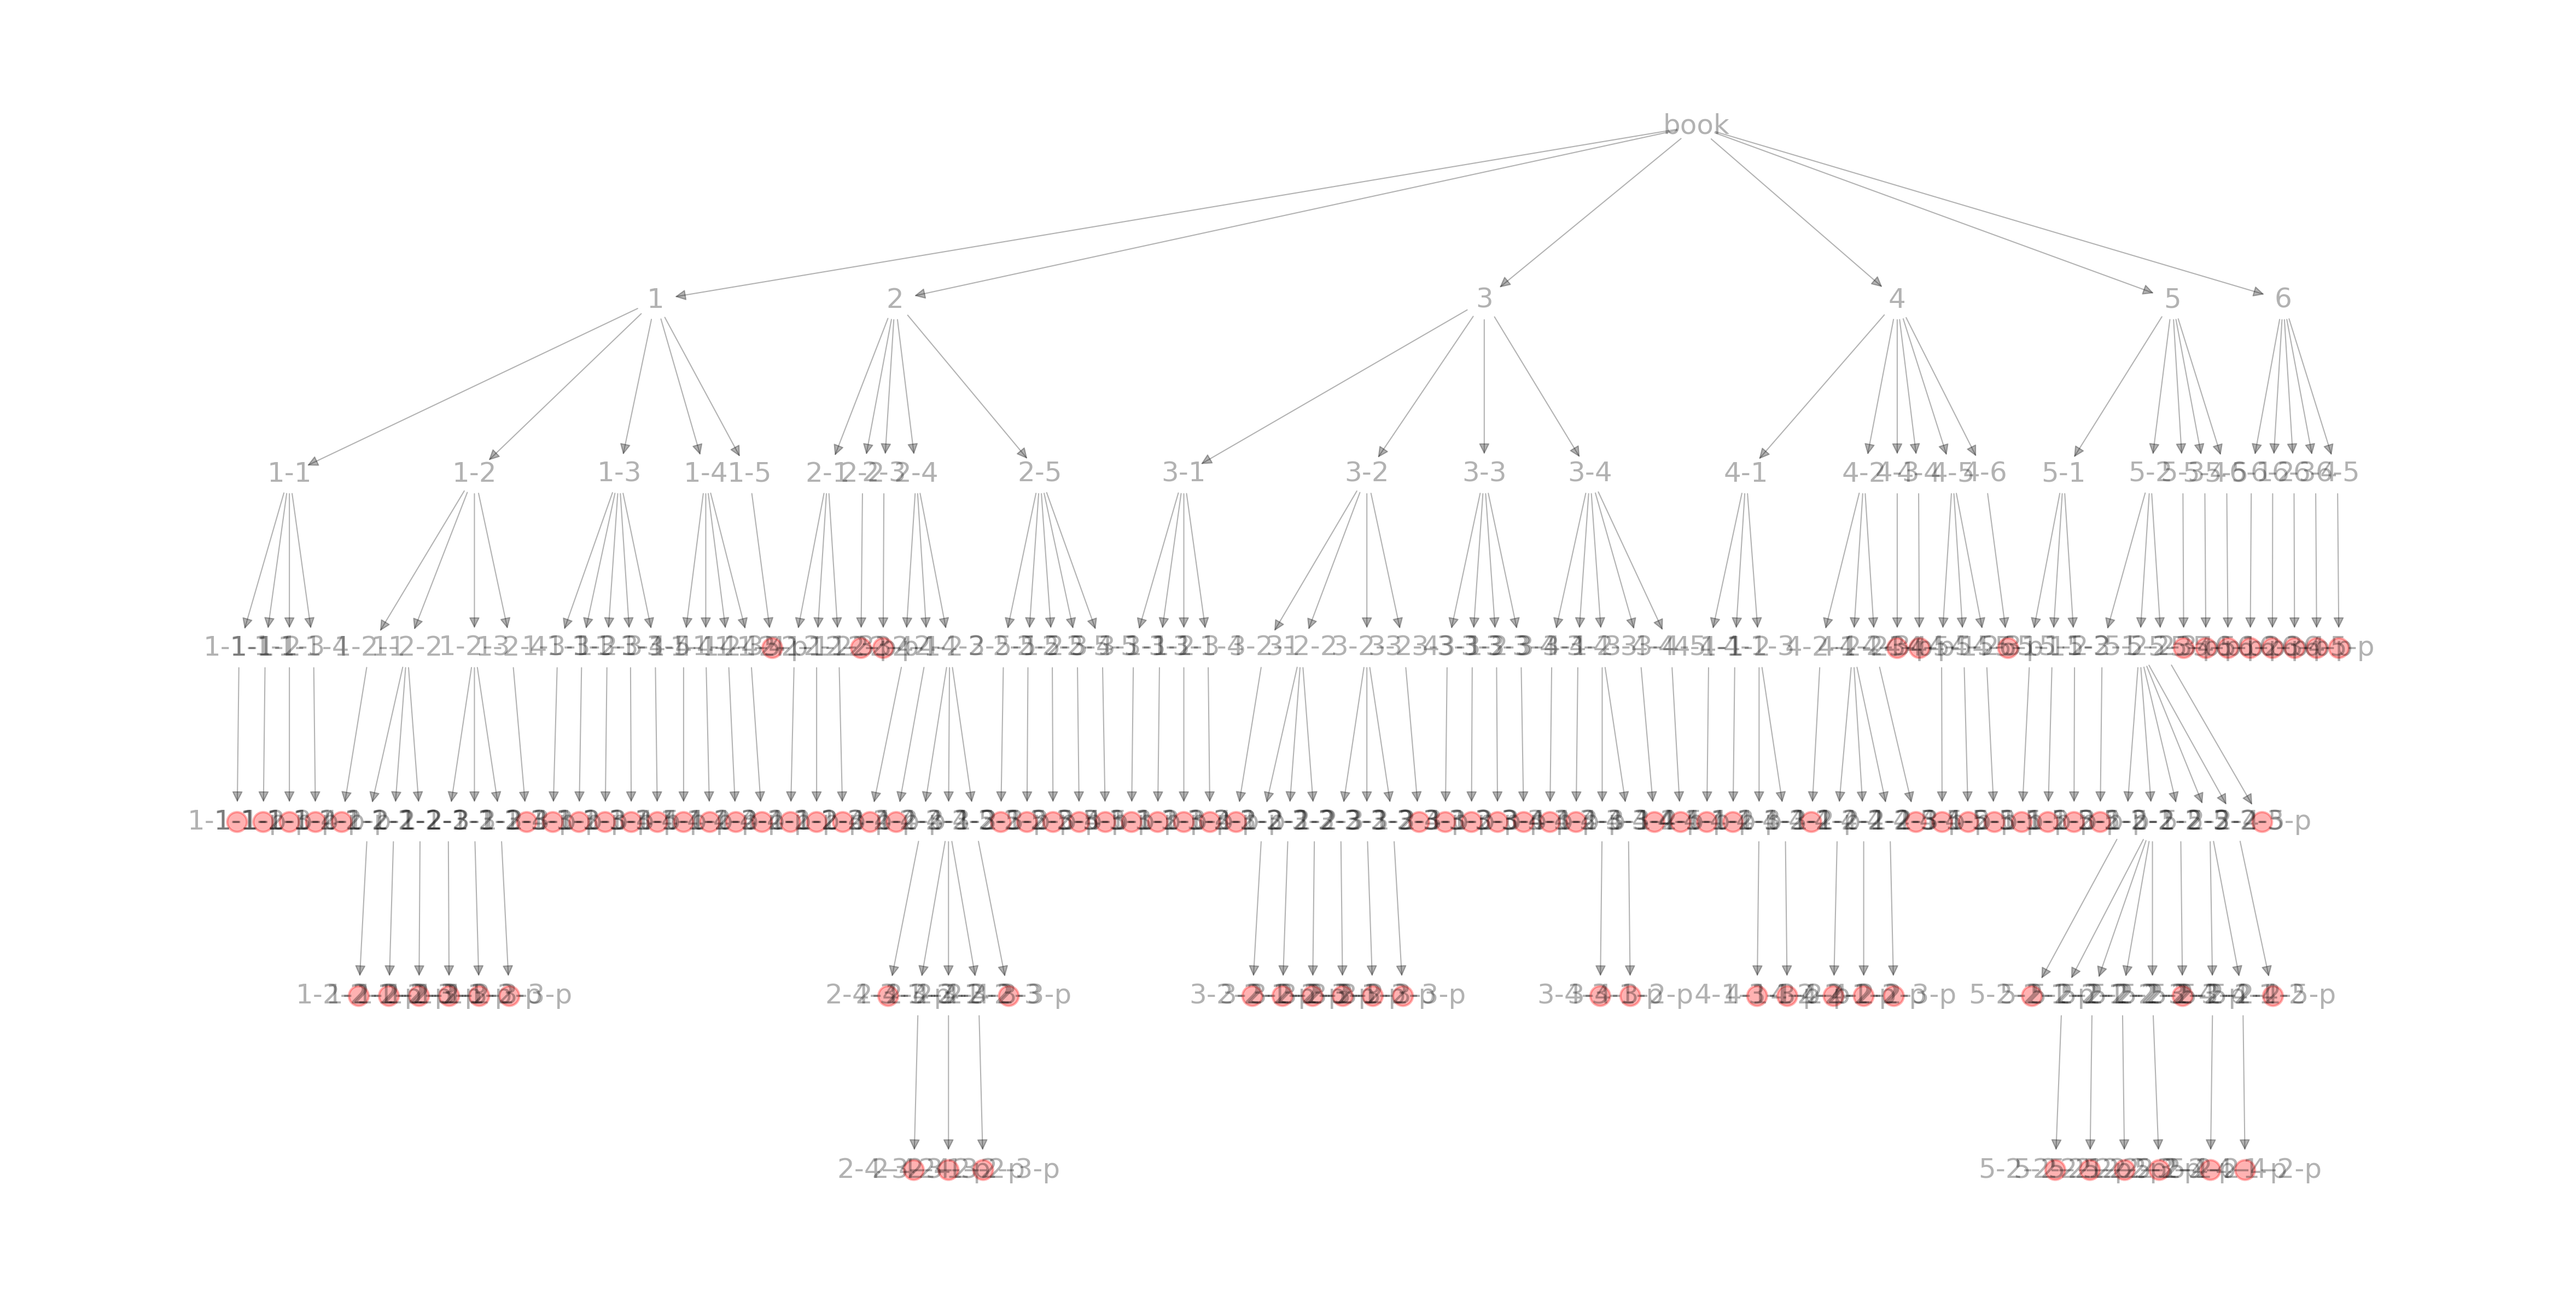

In [17]:
pos = graphviz_layout(book_graph, prog="dot")

# matplotlib settings
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 1, 1)

# 리프 노드(본문 노드)를 빨갛게
node_color_list = ["r" if "p" in s else "w" for s in list(book_graph.nodes)]

# draw the network
nx.draw(book_graph,
        ax=ax,
        pos=pos,
        with_labels=True,
        node_size=300,
        node_color=node_color_list,
        alpha=0.3,
        node_shape='.',
        width=0.5)

print("book에서 나오는 화살표의 끝이 장을 나타내며, 그 아래가 절, 그 아래가 소절입니다.\n이 노드들은 해당 장, 절의 제목이나 개요 정보를 가지고 있습니다.\n그리고 빨간 원으로 표시된 말단 노드는 본문의 내용을 정보로 가지고 있는 노드입니다.")

## 책 작성

### latexmkrc 파일 작성

In [18]:
# 홈 디렉터리 경로를 가져오기
home_dir = os.path.expanduser("~")

# .latexmkrc 파일의 경로를 생성
latexmkrc_path = os.path.join(home_dir, ".latexmkrc")

# latexmkrc 파일의 내용
content = '''$latex = 'lualatex -synctex=1 -halt-on-error -interaction=nonstopmode %O %S';
$bibtex = 'bibtex %O %S';
$biber = 'biber %O %S';
$makeindex = 'makeindex %O -o %D %S';
$dvipdf = 'dvipdfmx %O -o %D %S';

$max_repeat = 5;
$pdf_mode = 4;'''

# 파일을 생성하고 내용을 작성하기
try:
    with open(latexmkrc_path, "w") as file:
        file.write(content)
    print(f".latexmkrc 파일이 {latexmkrc_path}에 성공적으로 생성되었습니다.")
except IOError as e:
    print(f"파일 생성 중 오류가 발생했습니다: {e}")

.latexmkrc 파일이 /root/.latexmkrc에 성공적으로 생성되었습니다.


### LaTeX로 본문 작성

### LaTeX 문서 작성

In [19]:
# pylatex를 사용하여 PDF 생성
geometry_options = {"tmargin": "3cm", "lmargin": "3cm"}
doc = Document(documentclass="report", geometry_options=geometry_options)

# 프리앰블 및 제목 추가
doc.packages.append(Package('kotex'))
doc.packages.append(Package('amsmath'))
doc.packages.append(Package('amssymb'))
doc.packages.append(Package('amsfonts'))
doc.packages.append(Package('mathtools'))
doc.packages.append(Package('bm'))
doc.packages.append(Package('physics'))
doc.packages.append(Package('inputenc', options="utf8"))
doc.packages.append(Package('listingsutf8'))
doc.packages.append(Package('jvlisting'))
doc.packages.append(Package('color'))
doc.packages.append(Package('underscore', options="strings"))
doc.preamble.append(Command("title", book_graph.nodes[book_node_name]["title"]))
doc.preamble.append(NoEscape(r'''
\lstset{
    inputencoding=utf8,
}
'''))
doc.preamble.append(Command("date", NoEscape(r"\today")))
doc.append(NoEscape(r"\maketitle"))
doc.append(NoEscape(r"\tableofcontents"))
doc.append(NoEscape(r'\lstset{ backgroundcolor={\color[gray]{.90}}, breaklines = true, breakindent = 10pt, basicstyle = \ttfamily\scriptsize, commentstyle = {\itshape \color[cmyk]{1,0.4,1,0}}, classoffset = 0, keywordstyle = {\bfseries \color[cmyk]{0,1,0,0}}, stringstyle = {\ttfamily \color[rgb]{0,0,1}}, frame = TBrl, framesep = 5pt, numbers = left, stepnumber = 1, numberstyle = \tiny, tabsize = 4, captionpos = t}'))

In [20]:
# 본문 내용을 가진 노드를 순서대로 정렬
content_str_list = extract_content_list(list(book_graph.nodes))
sorted_content_str_list = sort_strings(content_str_list)

# 본문 추가
for heading_number_str in sorted_content_str_list:
    heading_number = custom_sort_key(heading_number_str)

    # 장 제목 추가
    if len(heading_number[1:]) == 0 or all(x == 1 for x in heading_number[1:]):
        node_name = "-".join(map(str, heading_number[0:1]))
        with doc.create(Chapter(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 절 제목 추가
    if (len(heading_number[2:]) == 0 and len(heading_number[:2]) > 1) or (len(heading_number[2:]) > 0 and all(x == 1 for x in heading_number[2:])):
        node_name = "-".join(map(str, heading_number[0:2]))
        with doc.create(Section(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 소절 제목 추가
    if (len(heading_number[3:]) == 0 and len(heading_number[:3]) > 2) or (len(heading_number[3:]) > 0 and all(x == 1 for x in heading_number[3:])):
        node_name = "-".join(map(str, heading_number[0:3]))
        with doc.create(Subsection(book_graph.nodes[node_name]["title"], label=False)):
            doc.append(NoEscape(book_graph.nodes[node_name]["summary"].replace("\\\\","\\")))

    # 본문 추가
    tex_file_path = book_graph.nodes[heading_number_str]["content_file_path"]
    with open(tex_file_path, "r", encoding='UTF-8') as file:
        tex_content = file.read()
        doc.append(NoEscape(tex_content))

### PDF 파일 작성


In [21]:
# 컴파일. /content/textbook.pdf 파일이 생성됩니다.
n_displayed_line = 10
isErrorOccured = False

try:
    doc.generate_pdf(book_node["title"], compiler="latexmk", clean_tex=False)
except:
    log_file_path = "/content/" + book_node["title"] + ".log"

    # 로그 파일 내용을 읽어옵니다.
    with open(log_file_path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

    # 에러 출력 패턴을 정의합니다 (file-line-error 옵션 형식)
    pattern = r'([a-zA-Z0-9_.]+):(\d+): (.+)'

    for i, line in enumerate(lines):
        match = re.search(pattern, line)
        if match:
            isErrorOccured = True
            print(f"Line: {match.group(2)}")
            print(f"Message: \n  {match.group(3)}")
            for j in range(i+1, min(i+n_displayed_line, len(lines))):
                print(lines[j].strip())
            print("-" * 40)

if isErrorOccured:
    files.download("/content/" + book_node["title"] + ".tex")
    raise Exception("TeX 파일을 컴파일하는 중 에러가 발생했습니다. 다시 실행하거나, 위의 에러 내용을 참조하여 에러를 수정한 후 컴파일 해주세요.")

In [22]:
# 다운로드
if tex_output:
    files.download("/content/" + book_node["title"] + ".tex")

if pdf_output:
    files.download("/content/" + book_node["title"] + ".pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Markdown 파일 작성

In [23]:
def clean_markdown_content(content):
    # 첫 번째 제목 앞의 부분(LaTeX 설정에 관한 부분)을 삭제
    content = content.split('#', 1)[1]

    # 개행 또는 공백이 앞뒤에 있을 경우에만 %를 삭제
    content = re.sub(r"(?<=\s)%|%(?=\s)", "", content)

    # %가 끝에 나타날 경우에만 삭제
    content = re.sub(r"%\s*$", "", content)

    # 여러 개의 개행을 하나의 개행으로 대체
    content = re.sub(r"\n{2,}", "\n\n", content)

    return content

def convert_to_latex_to_katex(content):
    # align, align* 환경의 변환
    content = re.sub(r'\\begin{align\*?}', r'$$\n\\begin{aligned}', content)
    content = re.sub(r'\\end{align\*?}', r'\\end{aligned}\n$$', content)

    # equation, equation* 환경의 변환
    content = re.sub(r'\\begin{equation\*?}', r'$$', content)
    content = re.sub(r'\\end{equation\*?}', r'$$', content)

    return content

def transform_code_blocks(content):

    # language 옵션을 추출하여 처리
    def replace_lstlisting(match):
        options = match.group(1)
        code = match.group(2)
        # language 옵션을 찾기
        lang_match = re.search(r'language=([a-zA-Z]+)', options)
        lang = lang_match.group(1) if lang_match else ''
        # Markdown 형식으로 변환
        return f'```{lang}\n{code}\n```'

    # lstlisting의 변환 처리
    content = re.sub(r'\\begin{lstlisting}\[(.*?)\](.*?)\\end{lstlisting}', replace_lstlisting, content, flags=re.DOTALL)

    return content

In [24]:
if md_output:
    %pip install latex2markdown
    import latex2markdown

    with open("/content/" + book_node["title"] + ".tex", "r") as f:
        latex_string = f.read()

    # LaTeX를 Markdown으로 변환
    processed_latex_str = transform_code_blocks(latex_string)
    l2m = latex2markdown.LaTeX2Markdown(processed_latex_str)
    markdown_string = l2m.to_markdown()

    # Markdown 텍스트를 정리
    cleaned_md_str = clean_markdown_content(markdown_string)
    katex_md_str = convert_to_latex_to_katex(cleaned_md_str)

    with open("/content/" + book_node["title"] + ".md", "w") as f:
        f.write(katex_md_str)
    files.download("/content/" + book_node["title"] + ".md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for latex2markdown: filename=latex2markdown-0.2.1-py3-none-any.whl size=8983 sha256=dde48c28855fab03b1f7f3adf621c2ef35910ada4647da16342019ed6576d85c
  Stored in directory: /root/.cache/pip/wheels/48/d0/8a/5009532cfcf3a270e1126c6a46d73ab028737188faf768fbba
Successfully built latex2markdown


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>